In [1]:
# %load honest_net.py
import numpy as np
import pandas as pd

import seaborn as sns

# Apply the default theme
sns.set_theme()

df = pd.read_csv("../../data/honest_net.tsv", sep="\t")
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]


# C&P from https://stackoverflow.com/a/39513799
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad / np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g


def parse_array(s):
    try:
        return np.fromstring(s, dtype=float, sep="|")
    except TypeError:
        return np.array([float("nan")])


def expand(row):
    compute = parse_array(row.compute)
    weakest = np.argmin(compute)
    strongest = np.argmax(compute)
    d = {}

    def wsg(k, v):
        d[k + "_weakest"] = v[weakest]
        d[k + "_strongest"] = v[strongest]
        d[k + "_gini"] = gini(v)

    rcompute = compute / np.sum(compute)
    wsg("compute", rcompute)
    activations = parse_array(row.activations)
    assert np.sum(activations) == row.number_activations or row.error
    ractivations = activations / np.sum(activations)
    wsg("activations", ractivations)
    reward = parse_array(row.reward)
    rreward = reward / np.sum(reward)
    wsg("reward", rreward)
    efficiency = rreward / ractivations
    wsg("efficiency", efficiency)
    d["activations_compute_gini_delta"] = d["activations_gini"] - d["compute_gini"]
    d["reward_activations_gini_delta"] = d["reward_gini"] - d["activations_gini"]
    return d


df = df.join(df.apply(expand, axis=1, result_type="expand"))

## Incentive Schemes for Georges  Protocol

In [2]:
d = df.query('protocol in ["tailstormll", "tailstorm"]')

### Efficiency of the weakest miner

We pick the weakest miner by compute power and calculate its

efficiency = relative reward / relative activations

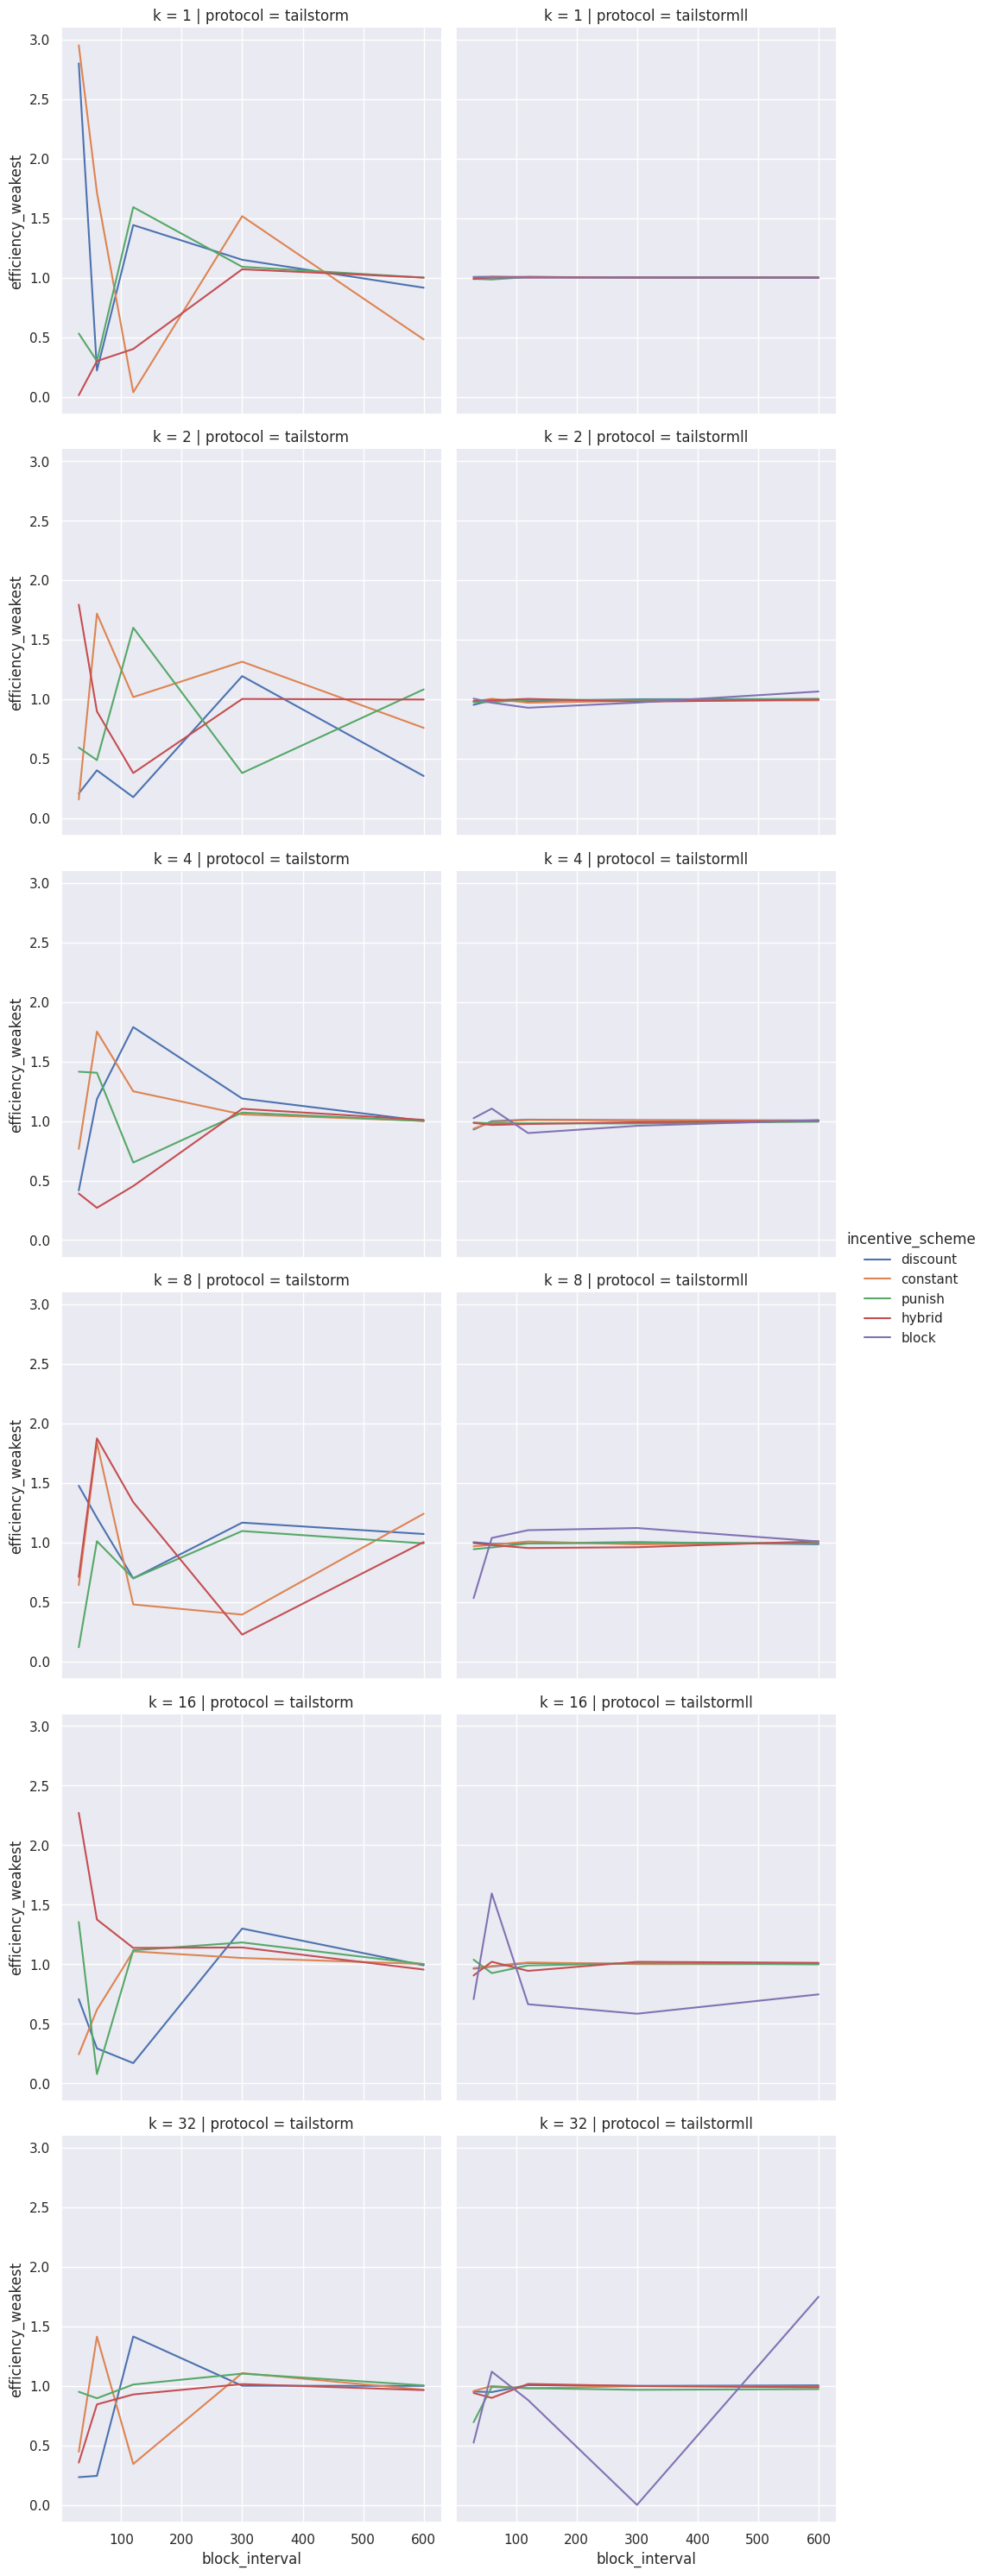

In [3]:
sns.relplot(
    data=d,
    x="block_interval",
    y="efficiency_weakest",
    col="protocol",
    row="k",
    hue="incentive_scheme",
    kind="line",
)

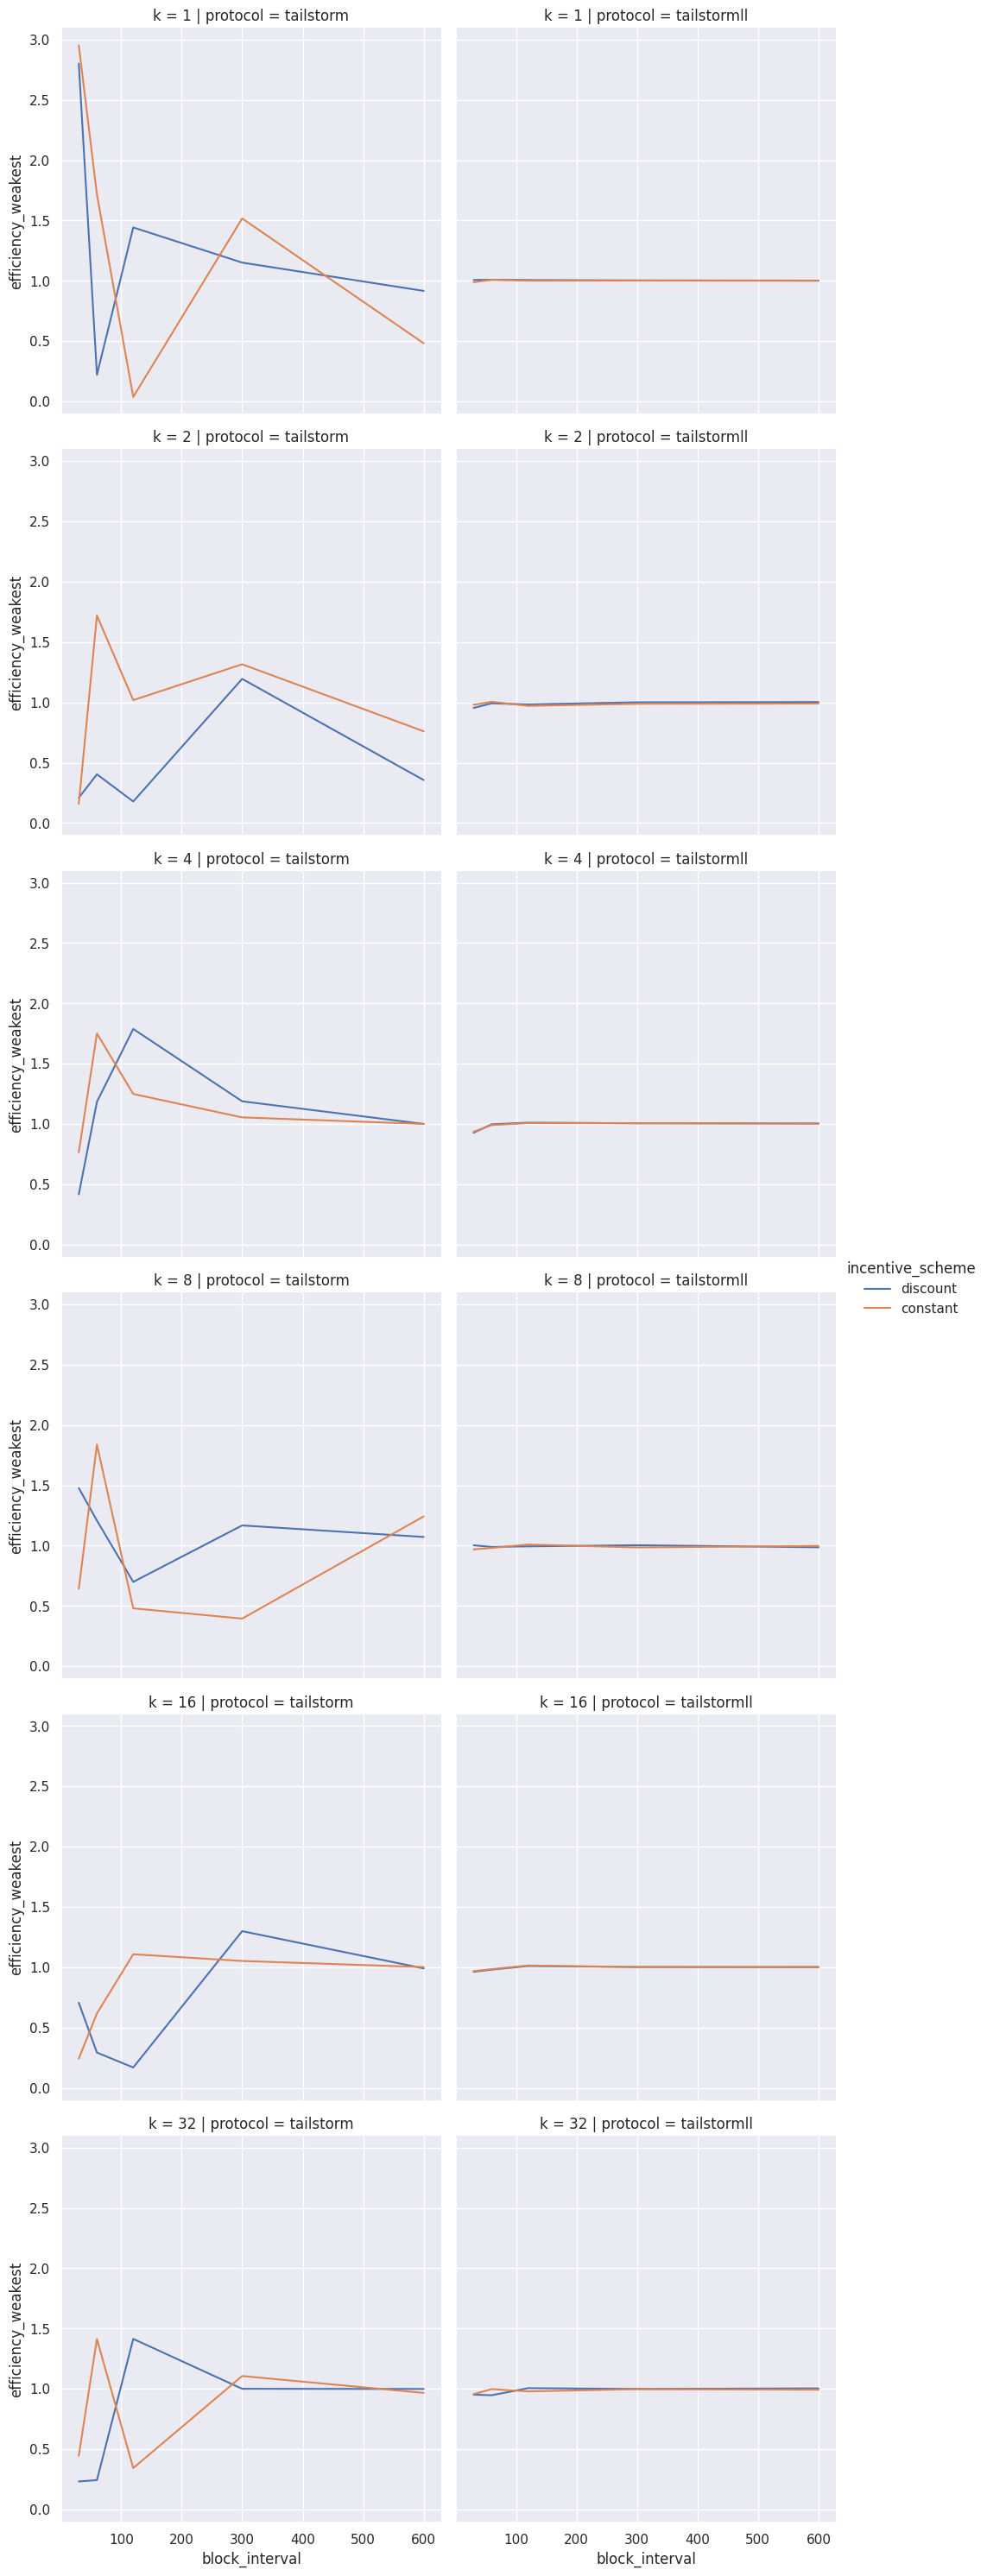

In [4]:
sns.relplot(
    data=d.query('incentive_scheme in ["constant", "discount"]'),
    x="block_interval",
    y="efficiency_weakest",
    col="protocol",
    row="k",
    hue="incentive_scheme",
    kind="line",
)

In [5]:
eff = d.rename(
    columns={"incentive_scheme": "Incentive Scheme", "block_interval": "Block Interval"}
).pivot(
    index=["Block Interval", "k", "protocol"],
    columns=["Incentive Scheme"],
    values="efficiency_weakest",
)
eff.style.to_latex(buf="../../tex/george-reward-inequality/tab/efficiency-weakest.tex")
eff

Incentive Scheme                  block  constant  discount    hybrid  \
Block Interval k  protocol                                              
30.0           1  tailstorm         NaN  2.952738  2.800834  0.013760   
                  tailstormll  1.005801  0.988958  1.007340  0.991009   
               2  tailstorm         NaN  0.159853  0.209980  1.795080   
                  tailstormll  1.006777  0.980600  0.954556  0.988079   
               4  tailstorm         NaN  0.765931  0.417418  0.390828   
                  tailstormll  1.023416  0.936125  0.928427  0.984108   
               8  tailstorm         NaN  0.642620  1.477451  0.711415   
                  tailstormll  0.533791  0.968849  1.003143  0.995998   
               16 tailstorm         NaN  0.242624  0.705978  2.270846   
                  tailstormll  0.706215  0.967594  0.962482  0.905415   
               32 tailstorm         NaN  0.445859  0.232620  0.354972   
                  tailstormll  0.522393  0.956220  0.951852  0.939641   
60.0           1  tailstorm         NaN  1.715601  0.221635  0.300841   
                  tailstormll  1.002298  1.009083  1.009017  1.002298   
               2  tailstorm         NaN  1.720171  0.404612  0.898913   
                  tailstormll  0.972372  1.005569  0.992918  0.991918   
               4  tailstorm         NaN  1.750793  1.184038  0.270861   
                  tailstormll  1.104159  0.991655  0.998060  0.966544   
               8  tailstorm         NaN  1.838546  1.208061  1.875213   
                  tailstormll  1.038961  0.981200  0.989562  0.979923   
               16 tailstorm         NaN  0.617369  0.292844  1.375033   
                  tailstormll  1.594303  0.984395  0.980343  1.020699   
               32 tailstorm         NaN  1.413090  0.243711  0.843897   
                  tailstormll  1.118756  0.998084  0.947247  0.898419   
120.0          1  tailstorm         NaN  0.038328  1.442841  0.402188   
                  tailstormll  1.001433  1.001392  1.006745  1.006745   
               2  tailstorm         NaN  1.019313  0.179170  0.381695   
                  tailstormll  0.929947  0.972023  0.983815  1.004578   
               4  tailstorm         NaN  1.249341  1.788406  0.453588   
                  tailstormll  0.898822  1.008076  1.011515  0.974711   
               8  tailstorm         NaN  0.480551  0.699707  1.339837   
                  tailstormll  1.104219  1.009214  0.994183  0.954389   
               16 tailstorm         NaN  1.107788  0.169527  1.136815   
                  tailstormll  0.663680  1.014610  1.010168  0.943954   
               32 tailstorm         NaN  0.343511  1.414179  0.927421   
                  tailstormll  0.880359  0.979010  1.005757  1.015630   
300.0          1  tailstorm         NaN  1.517220  1.151410  1.071582   
                  tailstormll  1.002406  1.002305  1.003714  1.002506   
               2  tailstorm         NaN  1.316482  1.195468  1.003664   
                  tailstormll  0.973110  0.988850  1.001160  0.980824   
               4  tailstorm         NaN  1.055298  1.188694  1.102324   
                  tailstormll  0.959689  1.006441  1.006548  0.989809   
               8  tailstorm         NaN  0.395349  1.167624  0.227495   
                  tailstormll  1.122510  0.985364  1.003693  0.961212   
               16 tailstorm         NaN  1.052189  1.299293  1.140600   
                  tailstormll  0.584049  1.001358  1.002053  1.020033   
               32 tailstorm         NaN  1.106537  1.000512  1.014295   
                  tailstormll  0.000000  0.997397  0.999355  0.998254   
600.0          1  tailstorm         NaN  0.482528  0.916885  1.001803   
                  tailstormll  1.000901  1.001001  1.002205  1.001502   
               2  tailstorm         NaN  0.760983  0.356759  0.998897   
                  tailstormll  1.066339  0.991123  1.003613  0.998413   
               4  tailstorm         NaN  1.001201  1.00105

### Reward Gini Fairness

We compare the rewards of all miners using the Gini coefficient. A lower coefficient implies more fairness. All numbers should be compared to the Gini coefficient of the compute powers.

In [6]:
d.compute_gini.unique()

array([0.3])

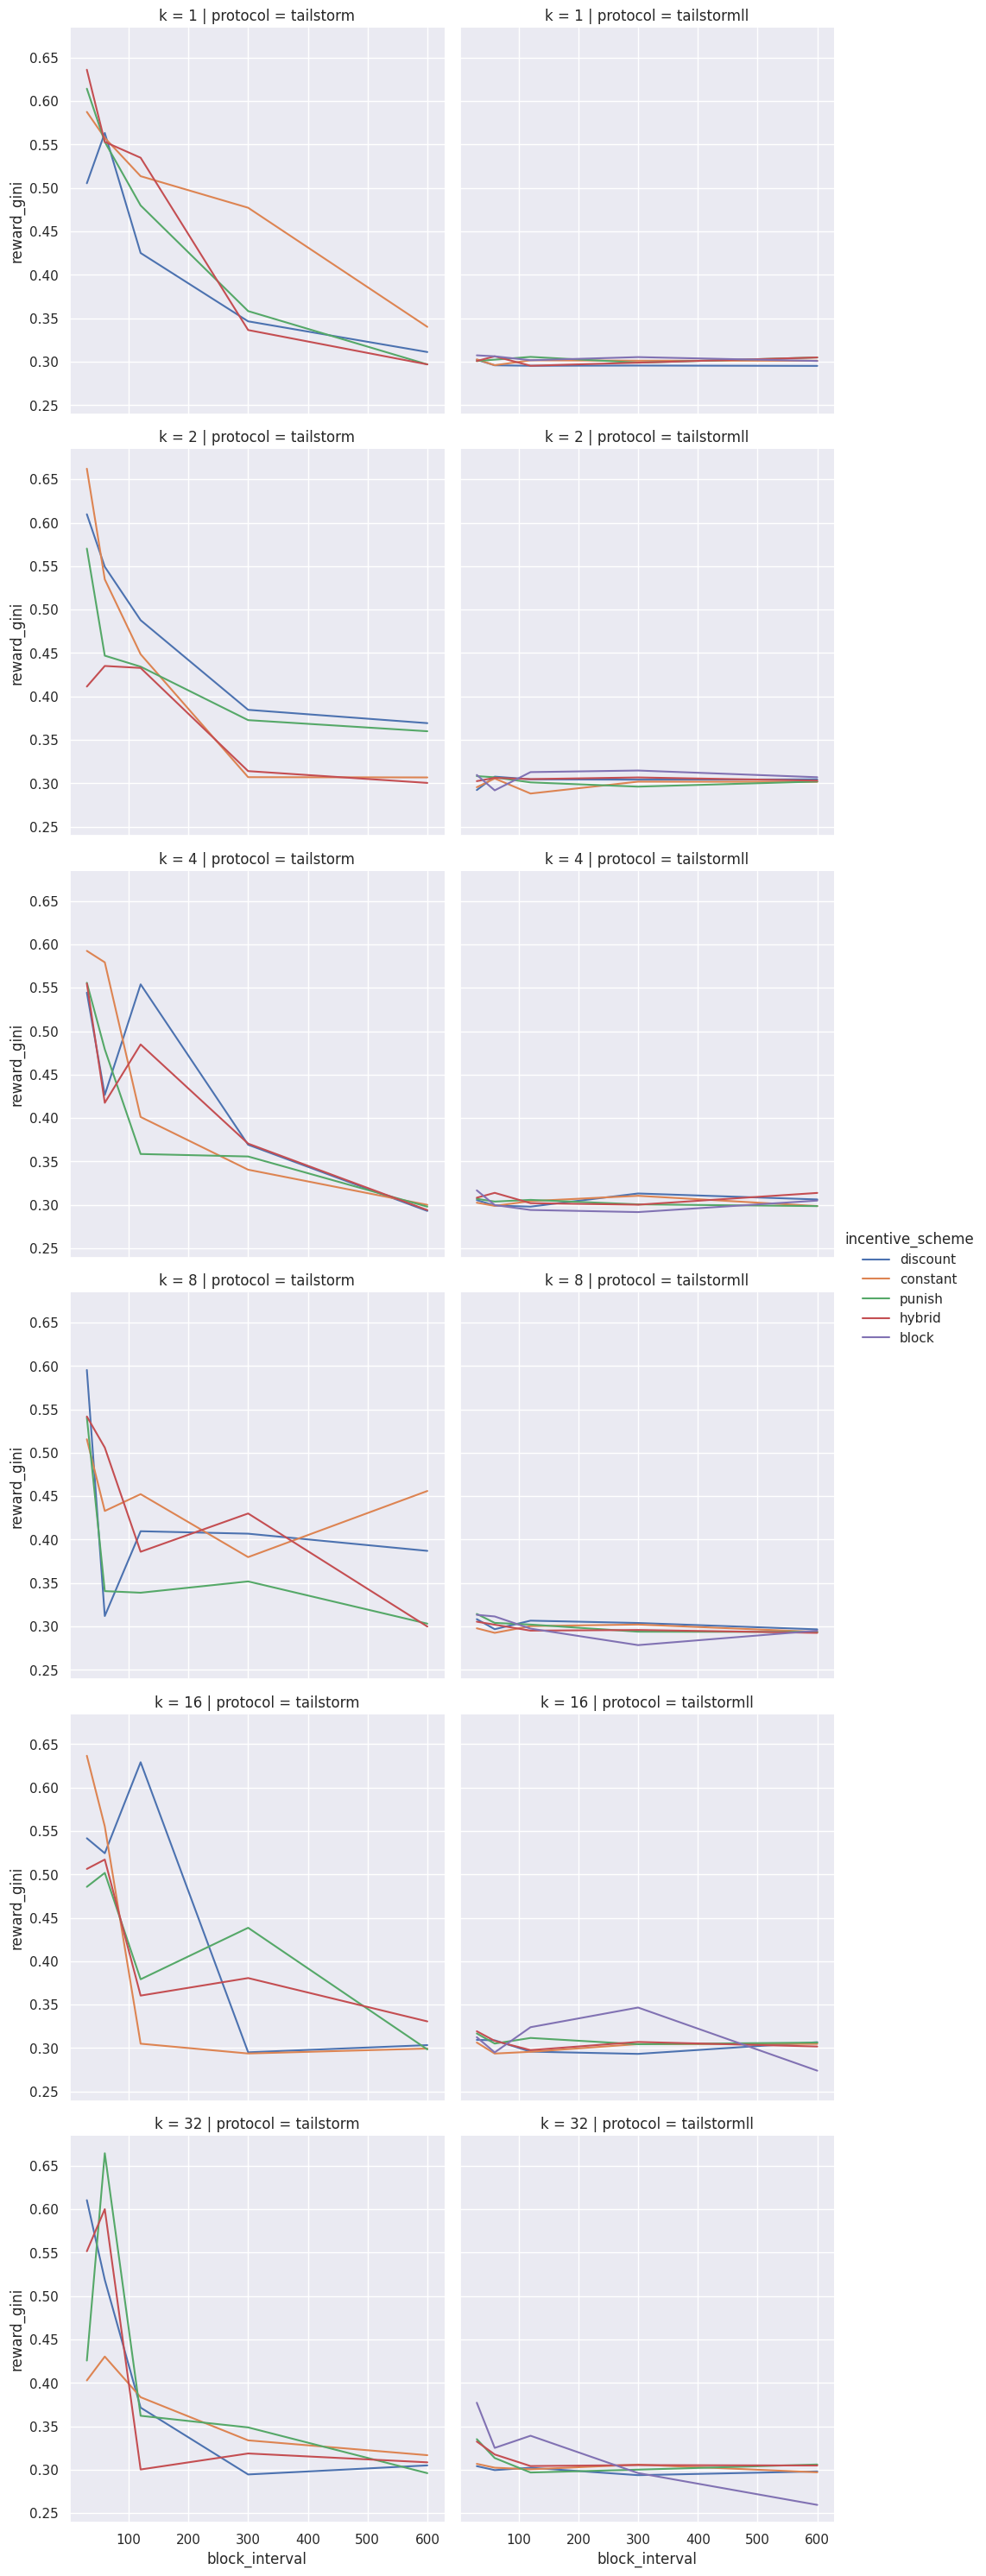

In [7]:
sns.relplot(
    data=d,
    x="block_interval",
    y="reward_gini",
    col="protocol",
    row="k",
    hue="incentive_scheme",
    kind="line",
)

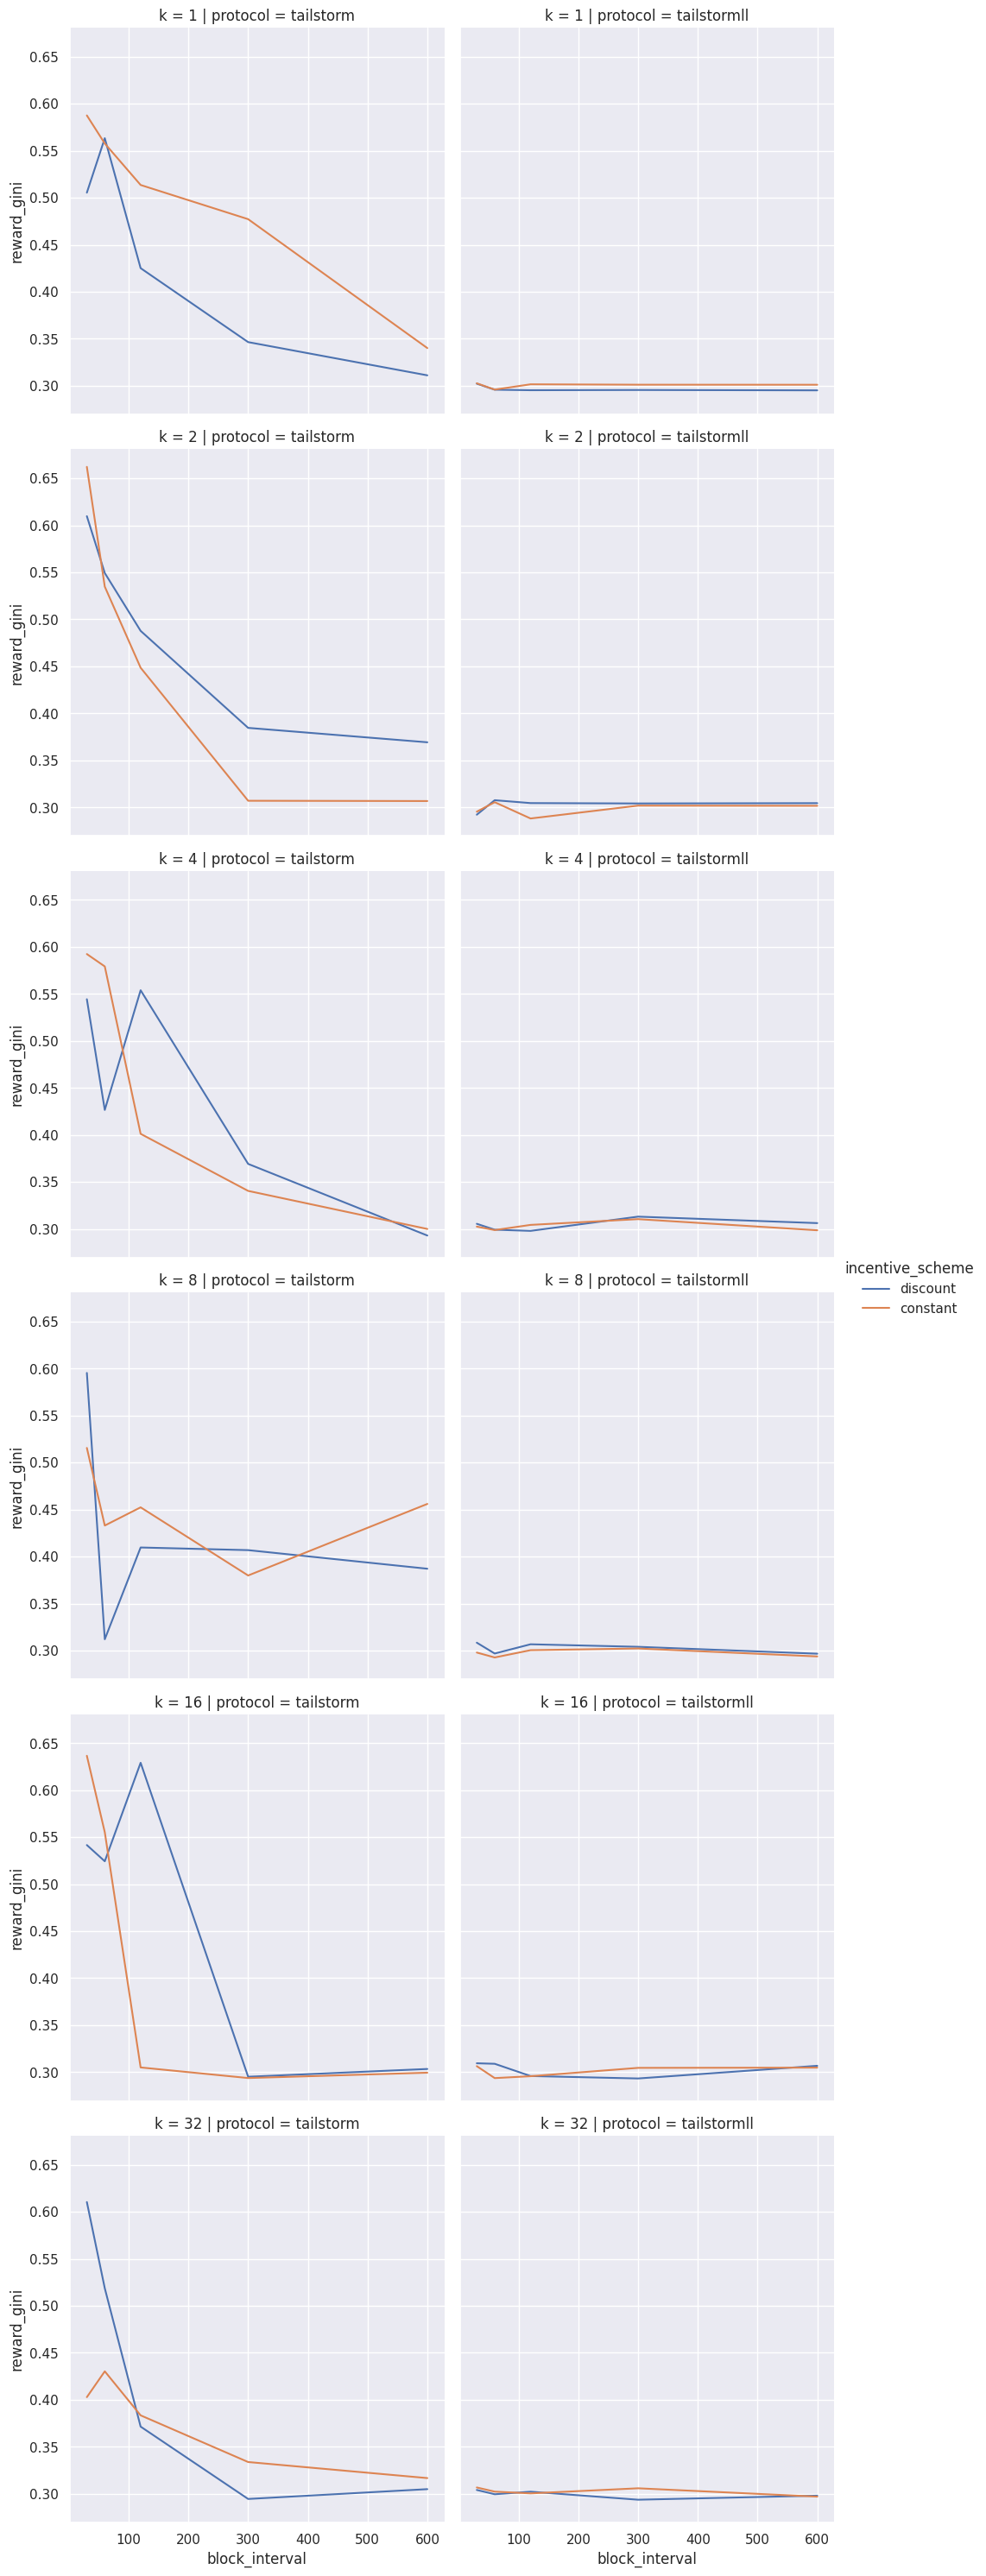

In [8]:
sns.relplot(
    data=d[
        (d["incentive_scheme"] == "constant") | (d["incentive_scheme"] == "discount")
    ],
    x="block_interval",
    y="reward_gini",
    col="protocol",
    row="k",
    hue="incentive_scheme",
    kind="line",
)

In [9]:
gini = d.rename(
    columns={"incentive_scheme": "Incentive Scheme", "block_interval": "Block Interval"}
).pivot(
    index=["Block Interval", "k", "protocol"],
    columns=["Incentive Scheme"],
    values="reward_gini",
)
gini.style.to_latex(buf="../../tex/george-reward-inequality/tab/reward-gini.tex")
gini

Incentive Scheme                  block  constant  discount    hybrid  \
Block Interval k  protocol                                              
30.0           1  tailstorm         NaN  0.587572  0.505424  0.636153   
                  tailstormll  0.307335  0.302677  0.302258  0.300762   
               2  tailstorm         NaN  0.662214  0.609753  0.411381   
                  tailstormll  0.309604  0.295456  0.292226  0.302476   
               4  tailstorm         NaN  0.592448  0.544398  0.554911   
                  tailstormll  0.316751  0.302550  0.305534  0.308256   
               8  tailstorm         NaN  0.515583  0.595354  0.541794   
                  tailstormll  0.313424  0.297941  0.308432  0.305553   
               16 tailstorm         NaN  0.636570  0.541597  0.506295   
                  tailstormll  0.312542  0.306421  0.309495  0.319392   
               32 tailstorm         NaN  0.402808  0.610322  0.551521   
                  tailstormll  0.377133  0.306741  0.304080  0.332442   
60.0           1  tailstorm         NaN  0.557737  0.563378  0.553066   
                  tailstormll  0.306208  0.295961  0.295839  0.306187   
               2  tailstorm         NaN  0.534804  0.549274  0.435091   
                  tailstormll  0.291880  0.305540  0.307654  0.306301   
               4  tailstorm         NaN  0.579281  0.426628  0.417549   
                  tailstormll  0.299835  0.298848  0.299272  0.313880   
               8  tailstorm         NaN  0.433025  0.312042  0.505996   
                  tailstormll  0.311570  0.292689  0.296891  0.302086   
               16 tailstorm         NaN  0.555266  0.524358  0.517093   
                  tailstormll  0.295058  0.293719  0.308945  0.308324   
               32 tailstorm         NaN  0.430271  0.518618  0.599971   
                  tailstormll  0.325083  0.302310  0.299527  0.317553   
120.0          1  tailstorm         NaN  0.513600  0.425138  0.534823   
                  tailstormll  0.301694  0.301591  0.295309  0.295309   
               2  tailstorm         NaN  0.448560  0.487779  0.432817   
                  tailstormll  0.312884  0.288208  0.304583  0.304818   
               4  tailstorm         NaN  0.401231  0.553932  0.484736   
                  tailstormll  0.294161  0.304366  0.298001  0.301986   
               8  tailstorm         NaN  0.452384  0.409678  0.386051   
                  tailstormll  0.297567  0.300446  0.306723  0.295243   
               16 tailstorm         NaN  0.305058  0.629128  0.360439   
                  tailstormll  0.324065  0.295739  0.295921  0.297693   
               32 tailstorm         NaN  0.383449  0.371459  0.300250   
                  tailstormll  0.339088  0.300446  0.302243  0.304198   
300.0          1  tailstorm         NaN  0.477242  0.346471  0.336434   
                  tailstormll  0.305293  0.301163  0.295544  0.298897   
               2  tailstorm         NaN  0.307056  0.384588  0.314038   
                  tailstormll  0.314709  0.301893  0.304189  0.306747   
               4  tailstorm         NaN  0.340523  0.369239  0.370552   
                  tailstormll  0.291714  0.310487  0.313151  0.300209   
               8  tailstorm         NaN  0.379884  0.406855  0.430127   
                  tailstormll  0.278566  0.302254  0.304038  0.295992   
               16 tailstorm         NaN  0.293792  0.295160  0.380638   
                  tailstormll  0.346699  0.304610  0.293329  0.307085   
               32 tailstorm         NaN  0.333790  0.294513  0.318673   
                  tailstormll  0.296129  0.305867  0.293705  0.305323   
600.0          1  tailstorm         NaN  0.340105  0.311134  0.296894   
                  tailstormll  0.300841  0.301121  0.295169  0.304887   
               2  tailstorm         NaN  0.306760  0.369260  0.300452   
                  tailstormll  0.306985  0.301705  0.304516  0.303051   
               4  tailstorm         NaN  0.300040  0.29304